In [1]:
# Deribit Premium Rate & Volume Pressure Monitor
# Advanced monitoring script for premium tracking and market pressure analysis

import requests
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Optional: For Google Sheets integration (uncomment if needed)
# import gspread
# from google.oauth2.service_account import Credentials

class DeribitPremiumMonitor:
    def __init__(self, instrument="BTC-PERPETUAL", history_length=1000):
        self.instrument = instrument
        self.currency = instrument.split('-')[0]
        self.deribit_base_url = "https://www.deribit.com/api/v2/public"
        
        # Data storage
        self.history_length = history_length
        self.data_history = deque(maxlen=history_length)
        
        # Analysis parameters
        self.volume_window = 20  # Rolling window for volume analysis
        self.pressure_threshold = 0.3  # Threshold for buying/selling pressure
        
        print(f"🚀 Initialized Premium Monitor for {instrument}")
        
    def fetch_ticker_data(self):
        """Fetch basic ticker data"""
        try:
            url = f"{self.deribit_base_url}/ticker"
            params = {"instrument_name": self.instrument}
            response = requests.get(url, params=params, timeout=5)
            
            if response.status_code == 200:
                return response.json()["result"]
            return None
        except Exception as e:
            print(f"❌ Error fetching ticker: {e}")
            return None
    
    def fetch_index_price(self):
        """Fetch index price"""
        try:
            index_name = f"{self.currency.lower()}_usd"
            url = f"{self.deribit_base_url}/get_index_price"
            params = {"index_name": index_name}
            response = requests.get(url, params=params, timeout=5)
            
            if response.status_code == 200:
                return response.json()["result"]["index_price"]
            return None
        except Exception as e:
            print(f"❌ Error fetching index price: {e}")
            return None
    
    def fetch_order_book(self, depth=10):
        """Fetch order book data for volume analysis"""
        try:
            url = f"{self.deribit_base_url}/get_order_book"
            params = {
                "instrument_name": self.instrument,
                "depth": depth
            }
            response = requests.get(url, params=params, timeout=5)
            
            if response.status_code == 200:
                result = response.json()["result"]
                return {
                    "bids": result["bids"],
                    "asks": result["asks"],
                    "timestamp": result["timestamp"]
                }
            return None
        except Exception as e:
            print(f"❌ Error fetching order book: {e}")
            return None
    
    def fetch_recent_trades(self, count=50):
        """Fetch recent trades to analyze market vs limit orders"""
        try:
            url = f"{self.deribit_base_url}/get_last_trades_by_instrument"
            params = {
                "instrument_name": self.instrument,
                "count": count
            }
            response = requests.get(url, params=params, timeout=5)
            
            if response.status_code == 200:
                return response.json()["result"]["trades"]
            return None
        except Exception as e:
            print(f"❌ Error fetching trades: {e}")
            return None
    
    def analyze_order_book_pressure(self, order_book):
        """Analyze buying vs selling pressure from order book"""
        if not order_book:
            return {}
        
        try:
            # Calculate total volume on each side
            bid_volume = sum([float(bid[1]) for bid in order_book["bids"]])
            ask_volume = sum([float(ask[1]) for ask in order_book["asks"]])
            total_volume = bid_volume + ask_volume
            
            # Calculate weighted average prices for top levels
            top_bids = order_book["bids"][:5]
            top_asks = order_book["asks"][:5]
            
            bid_weighted_price = sum([float(bid[0]) * float(bid[1]) for bid in top_bids]) / sum([float(bid[1]) for bid in top_bids]) if top_bids else 0
            ask_weighted_price = sum([float(ask[0]) * float(ask[1]) for ask in top_asks]) / sum([float(ask[1]) for ask in top_asks]) if top_asks else 0
            
            # Calculate pressure metrics
            bid_ratio = bid_volume / total_volume if total_volume > 0 else 0.5
            ask_ratio = ask_volume / total_volume if total_volume > 0 else 0.5
            
            pressure_score = bid_ratio - ask_ratio  # +1 = all buying, -1 = all selling
            
            return {
                "bid_volume": bid_volume,
                "ask_volume": ask_volume,
                "total_ob_volume": total_volume,
                "bid_ratio": bid_ratio,
                "ask_ratio": ask_ratio,
                "pressure_score": pressure_score,
                "bid_weighted_price": bid_weighted_price,
                "ask_weighted_price": ask_weighted_price,
                "spread_bps": ((ask_weighted_price - bid_weighted_price) / bid_weighted_price * 10000) if bid_weighted_price > 0 else 0
            }
        except Exception as e:
            print(f"❌ Error analyzing order book: {e}")
            return {}
    
    def analyze_trade_pressure(self, trades):
        """Analyze market pressure from recent trades"""
        if not trades:
            return {}
        
        try:
            # Separate buy and sell trades
            buy_trades = [t for t in trades if t["direction"] == "buy"]
            sell_trades = [t for t in trades if t["direction"] == "sell"]
            
            # Calculate volumes
            buy_volume = sum([float(t["amount"]) for t in buy_trades])
            sell_volume = sum([float(t["amount"]) for t in sell_trades])
            total_trade_volume = buy_volume + sell_volume
            
            # Calculate trade pressure
            if total_trade_volume > 0:
                trade_pressure = (buy_volume - sell_volume) / total_trade_volume
            else:
                trade_pressure = 0
            
            # Analyze aggressive vs passive trades (simplified)
            market_buy_volume = sum([float(t["amount"]) for t in buy_trades])
            market_sell_volume = sum([float(t["amount"]) for t in sell_trades])
            
            return {
                "buy_volume": buy_volume,
                "sell_volume": sell_volume,
                "total_trade_volume": total_trade_volume,
                "trade_pressure": trade_pressure,
                "market_buy_volume": market_buy_volume,
                "market_sell_volume": market_sell_volume,
                "trade_count": len(trades),
                "avg_trade_size": total_trade_volume / len(trades) if trades else 0
            }
        except Exception as e:
            print(f"❌ Error analyzing trades: {e}")
            return {}
    
    def collect_market_data(self):
        """Collect all market data and calculate metrics"""
        timestamp = datetime.now()
        
        # Fetch all data
        ticker = self.fetch_ticker_data()
        index_price = self.fetch_index_price()
        order_book = self.fetch_order_book()
        trades = self.fetch_recent_trades()
        
        if not all([ticker, index_price]):
            return None
        
        # Calculate basic metrics
        mark_price = ticker["mark_price"]
        funding_8h = ticker["funding_8h"]
        
        # Premium calculations
        premium_rate = ((mark_price - index_price) / index_price) * 100
        premium_dollar = mark_price - index_price
        premium_bps = premium_rate * 100  # basis points
        
        # Analyze pressures
        ob_pressure = self.analyze_order_book_pressure(order_book)
        trade_pressure = self.analyze_trade_pressure(trades)
        
        # Create data point
        data_point = {
            "timestamp": timestamp,
            "mark_price": mark_price,
            "index_price": index_price,
            "premium_rate": premium_rate,
            "premium_dollar": premium_dollar,
            "premium_bps": premium_bps,
            "funding_8h": funding_8h,
            "funding_8h_annualized": funding_8h * 365 * 3,  # 3 times per day
            
            # Order book pressure
            **ob_pressure,
            
            # Trade pressure  
            **trade_pressure,
            
            # Additional ticker data
            "best_bid": ticker.get("best_bid_price", 0),
            "best_ask": ticker.get("best_ask_price", 0),
            "last_price": ticker.get("last_price", 0),
            "open_interest": ticker.get("open_interest", 0),
            "volume_24h": ticker.get("stats", {}).get("volume", 0),
        }
        
        return data_point
    
    def update_history(self):
        """Update data history"""
        data = self.collect_market_data()
        if data:
            self.data_history.append(data)
            return data
        return None
    
    def get_dataframe(self):
        """Convert history to pandas DataFrame"""
        if not self.data_history:
            return pd.DataFrame()
        
        df = pd.DataFrame(list(self.data_history))
        df.set_index('timestamp', inplace=True)
        return df
    
    def calculate_signals(self, df):
        """Calculate trading signals and funding predictions"""
        if len(df) < 10:
            return df
        
        # Rolling metrics
        df['premium_ma_short'] = df['premium_rate'].rolling(5).mean()
        df['premium_ma_long'] = df['premium_rate'].rolling(20).mean()
        df['pressure_ma'] = df['pressure_score'].rolling(10).mean()
        df['funding_ma'] = df['funding_8h'].rolling(10).mean()
        
        # Volatility
        df['premium_volatility'] = df['premium_rate'].rolling(20).std()
        
        # Momentum indicators
        df['premium_momentum'] = df['premium_rate'] - df['premium_rate'].shift(5)
        df['pressure_momentum'] = df['pressure_score'] - df['pressure_score'].shift(5)
        
        # Trading signals
        df['premium_trend'] = np.where(df['premium_ma_short'] > df['premium_ma_long'], 1, -1)
        df['high_premium'] = np.where(df['premium_rate'] > df['premium_rate'].quantile(0.8), 1, 0)
        df['high_pressure'] = np.where(abs(df['pressure_score']) > self.pressure_threshold, 1, 0)
        
        # Funding prediction (simplified)
        df['funding_prediction'] = np.where(
            (df['premium_rate'] > 0) & (df['pressure_score'] > 0.2), 
            'INCREASING', 
            np.where(
                (df['premium_rate'] < 0) & (df['pressure_score'] < -0.2),
                'DECREASING',
                'STABLE'
            )
        )
        
        # Risk signals
        df['long_risk'] = np.where(
            (df['high_premium'] == 1) & (df['pressure_score'] > 0.3) & (df['funding_8h'] > 0.01),
            'HIGH_RISK',
            np.where(
                (df['premium_rate'] > 0.1) & (df['pressure_score'] > 0.2),
                'MEDIUM_RISK',
                'LOW_RISK'
            )
        )
        
        return df
    
    def print_analysis(self, latest_data):
        """Print current market analysis"""
        if not latest_data:
            print("❌ No data available")
            return
        
        print(f"\n📊 MARKET ANALYSIS - {latest_data['timestamp'].strftime('%H:%M:%S')}")
        print("=" * 60)
        
        # Price info
        print(f"💰 Mark Price: ${latest_data['mark_price']:,.2f}")
        print(f"📈 Index Price: ${latest_data['index_price']:,.2f}")
        print(f"💵 Premium: ${latest_data['premium_dollar']:+.2f} ({latest_data['premium_rate']:+.4f}%)")
        print(f"🏦 Funding 8h: {latest_data['funding_8h']:+.4f}% (Annual: {latest_data['funding_8h_annualized']:+.1f}%)")
        
        # Pressure analysis
        print(f"\n🔄 MARKET PRESSURE:")
        print(f"📊 Order Book Pressure: {latest_data.get('pressure_score', 0):+.3f} {'📈 BUYING' if latest_data.get('pressure_score', 0) > 0.1 else '📉 SELLING' if latest_data.get('pressure_score', 0) < -0.1 else '⚖️ NEUTRAL'}")
        print(f"💹 Trade Pressure: {latest_data.get('trade_pressure', 0):+.3f}")
        print(f"📦 Bid Volume: {latest_data.get('bid_volume', 0):,.0f} | Ask Volume: {latest_data.get('ask_volume', 0):,.0f}")
        
        # Get historical analysis
        df = self.get_dataframe()
        if len(df) > 0:
            df = self.calculate_signals(df)
            latest_signals = df.iloc[-1]
            
            print(f"\n⚠️ TRADING SIGNALS:")
            print(f"📊 Premium Trend: {'🔺 UP' if latest_signals.get('premium_trend', 0) > 0 else '🔻 DOWN'}")
            print(f"🚨 Long Risk Level: {latest_signals.get('long_risk', 'UNKNOWN')}")
            print(f"🔮 Funding Prediction: {latest_signals.get('funding_prediction', 'STABLE')}")
            
            # Risk assessment
            if latest_data.get('premium_rate', 0) > 0.1 and latest_data.get('pressure_score', 0) > 0.3:
                print(f"\n🚨 HIGH PREMIUM + HIGH BUYING PRESSURE")
                print(f"⚠️ Long perpetual positions may face high funding costs!")
                print(f"💡 Consider waiting for premium to decrease")
            elif latest_data.get('premium_rate', 0) < -0.05 and latest_data.get('pressure_score', 0) < -0.2:
                print(f"\n💰 NEGATIVE PREMIUM + SELLING PRESSURE")
                print(f"✅ Potentially good opportunity for long positions")
            
        print("=" * 60)
    
    def create_dashboard(self, save_plot=False):
        """Create visual dashboard"""
        df = self.get_dataframe()
        if len(df) < 10:
            print("❌ Not enough data for visualization")
            return
        
        df = self.calculate_signals(df)
        
        # Create figure with subplots
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        fig.suptitle(f'{self.instrument} - Premium & Pressure Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Premium Rate & Funding
        ax1 = axes[0]
        ax1.plot(df.index, df['premium_rate'], label='Premium Rate %', color='blue', linewidth=2)
        ax1.plot(df.index, df['premium_ma_short'], label='Premium MA(5)', color='lightblue', alpha=0.7)
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Add funding rate on secondary axis
        ax1_2 = ax1.twinx()
        ax1_2.plot(df.index, df['funding_8h'] * 100, label='Funding 8h %', color='red', alpha=0.7)
        ax1_2.set_ylabel('Funding Rate %', color='red')
        
        ax1.set_ylabel('Premium Rate %')
        ax1.set_title('Premium Rate vs Funding Rate')
        ax1.legend(loc='upper left')
        ax1_2.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Market Pressure
        ax2 = axes[1]
        ax2.plot(df.index, df['pressure_score'], label='Order Book Pressure', color='green', linewidth=2)
        ax2.plot(df.index, df['trade_pressure'], label='Trade Pressure', color='orange', alpha=0.8)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.axhline(y=0.3, color='red', linestyle=':', alpha=0.7, label='High Pressure Threshold')
        ax2.axhline(y=-0.3, color='red', linestyle=':', alpha=0.7)
        ax2.set_ylabel('Pressure Score')
        ax2.set_title('Market Pressure Analysis')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Volume Analysis
        ax3 = axes[2]
        ax3.bar(df.index, df['bid_volume'], alpha=0.6, color='green', label='Bid Volume', width=0.0001)
        ax3.bar(df.index, -df['ask_volume'], alpha=0.6, color='red', label='Ask Volume', width=0.0001)
        ax3.set_ylabel('Volume')
        ax3.set_title('Order Book Volume Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Risk Signals
        ax4 = axes[3]
        risk_colors = {'HIGH_RISK': 'red', 'MEDIUM_RISK': 'orange', 'LOW_RISK': 'green'}
        for risk_level, color in risk_colors.items():
            mask = df['long_risk'] == risk_level
            if mask.any():
                ax4.scatter(df[mask].index, df[mask]['premium_rate'], 
                           c=color, label=f'{risk_level}', alpha=0.7, s=30)
        
        ax4.plot(df.index, df['premium_rate'], alpha=0.3, color='gray')
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_ylabel('Premium Rate %')
        ax4.set_xlabel('Time')
        ax4.set_title('Long Position Risk Assessment')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plot:
            plt.savefig(f'deribit_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', 
                       dpi=300, bbox_inches='tight')
            print(f"📊 Chart saved as PNG file")
        
        plt.show()
    
    def run_monitoring(self, interval=30, max_iterations=100):
        """Run continuous monitoring"""
        print(f"🚀 Starting monitoring every {interval} seconds...")
        print(f"📊 Will collect up to {max_iterations} data points")
        
        for i in range(max_iterations):
            try:
                print(f"\n📡 Update #{i+1}/{max_iterations}")
                
                # Update data
                latest_data = self.update_history()
                
                if latest_data:
                    # Print analysis every update
                    self.print_analysis(latest_data)
                    
                    # Create dashboard every 10 updates
                    if (i + 1) % 10 == 0 and len(self.data_history) >= 10:
                        print(f"\n📊 Creating dashboard...")
                        self.create_dashboard()
                
                # Wait for next update
                if i < max_iterations - 1:
                    print(f"⏳ Next update in {interval} seconds...")
                    time.sleep(interval)
                    
            except KeyboardInterrupt:
                print(f"\n⏹️ Monitoring stopped by user")
                break
            except Exception as e:
                print(f"❌ Error during monitoring: {e}")
                time.sleep(5)
        
        print(f"\n✅ Monitoring completed. Collected {len(self.data_history)} data points.")
        
        # Final dashboard
        if len(self.data_history) >= 10:
            print(f"📊 Creating final dashboard...")
            self.create_dashboard(save_plot=True)

# Example usage and testing functions
def test_single_update():
    """Test single data collection"""
    monitor = DeribitPremiumMonitor()
    data = monitor.update_history()
    if data:
        monitor.print_analysis(data)
        return True
    return False

def run_demo_monitoring():
    """Run demo monitoring for 10 minutes"""
    monitor = DeribitPremiumMonitor()
    monitor.run_monitoring(interval=30, max_iterations=20)

def analyze_current_market():
    """Quick market analysis"""
    monitor = DeribitPremiumMonitor()
    
    # Collect 5 data points quickly
    for i in range(5):
        monitor.update_history()
        time.sleep(2)
    
    # Show analysis
    df = monitor.get_dataframe()
    if len(df) > 0:
        monitor.create_dashboard()

if __name__ == "__main__":
    print("🚀 Deribit Premium & Volume Pressure Monitor")
    print("=" * 50)
    print("Available functions:")
    print("- test_single_update() - Test data collection")
    print("- run_demo_monitoring() - Run 20 updates demo")
    print("- analyze_current_market() - Quick 5-point analysis")
    print("=" * 50)
    
    # Uncomment to run automatic demo
    # run_demo_monitoring()

🚀 Deribit Premium & Volume Pressure Monitor
Available functions:
- test_single_update() - Test data collection
- run_demo_monitoring() - Run 20 updates demo
- analyze_current_market() - Quick 5-point analysis


In [2]:
test_single_update()

🚀 Initialized Premium Monitor for BTC-PERPETUAL

📊 MARKET ANALYSIS - 11:59:28
💰 Mark Price: $108,480.56
📈 Index Price: $108,471.10
💵 Premium: $+9.46 (+0.0087%)
🏦 Funding 8h: +0.0000% (Annual: +0.0%)

🔄 MARKET PRESSURE:
📊 Order Book Pressure: +0.629 📈 BUYING
💹 Trade Pressure: +0.529
📦 Bid Volume: 905,370 | Ask Volume: 205,920

⚠️ TRADING SIGNALS:
📊 Premium Trend: 🔻 DOWN
🚨 Long Risk Level: UNKNOWN
🔮 Funding Prediction: STABLE


True

In [3]:
analyze_current_market()

🚀 Initialized Premium Monitor for BTC-PERPETUAL
❌ Not enough data for visualization


🚀 Initialized Premium Monitor for BTC-PERPETUAL
🚀 Starting monitoring every 30 seconds...
📊 Will collect up to 20 data points

📡 Update #1/20

📊 MARKET ANALYSIS - 12:00:27
💰 Mark Price: $108,477.87
📈 Index Price: $108,467.20
💵 Premium: $+10.67 (+0.0098%)
🏦 Funding 8h: +0.0000% (Annual: +0.0%)

🔄 MARKET PRESSURE:
📊 Order Book Pressure: +0.287 📈 BUYING
💹 Trade Pressure: +0.526
📦 Bid Volume: 877,050 | Ask Volume: 486,170

⚠️ TRADING SIGNALS:
📊 Premium Trend: 🔻 DOWN
🚨 Long Risk Level: UNKNOWN
🔮 Funding Prediction: STABLE
⏳ Next update in 30 seconds...

📡 Update #2/20

📊 MARKET ANALYSIS - 12:00:57
💰 Mark Price: $108,477.34
📈 Index Price: $108,466.37
💵 Premium: $+10.97 (+0.0101%)
🏦 Funding 8h: +0.0000% (Annual: +0.0%)

🔄 MARKET PRESSURE:
📊 Order Book Pressure: -0.015 ⚖️ NEUTRAL
💹 Trade Pressure: +0.701
📦 Bid Volume: 637,250 | Ask Volume: 656,170

⚠️ TRADING SIGNALS:
📊 Premium Trend: 🔻 DOWN
🚨 Long Risk Level: UNKNOWN
🔮 Funding Prediction: STABLE
⏳ Next update in 30 seconds...

📡 Update #3/20


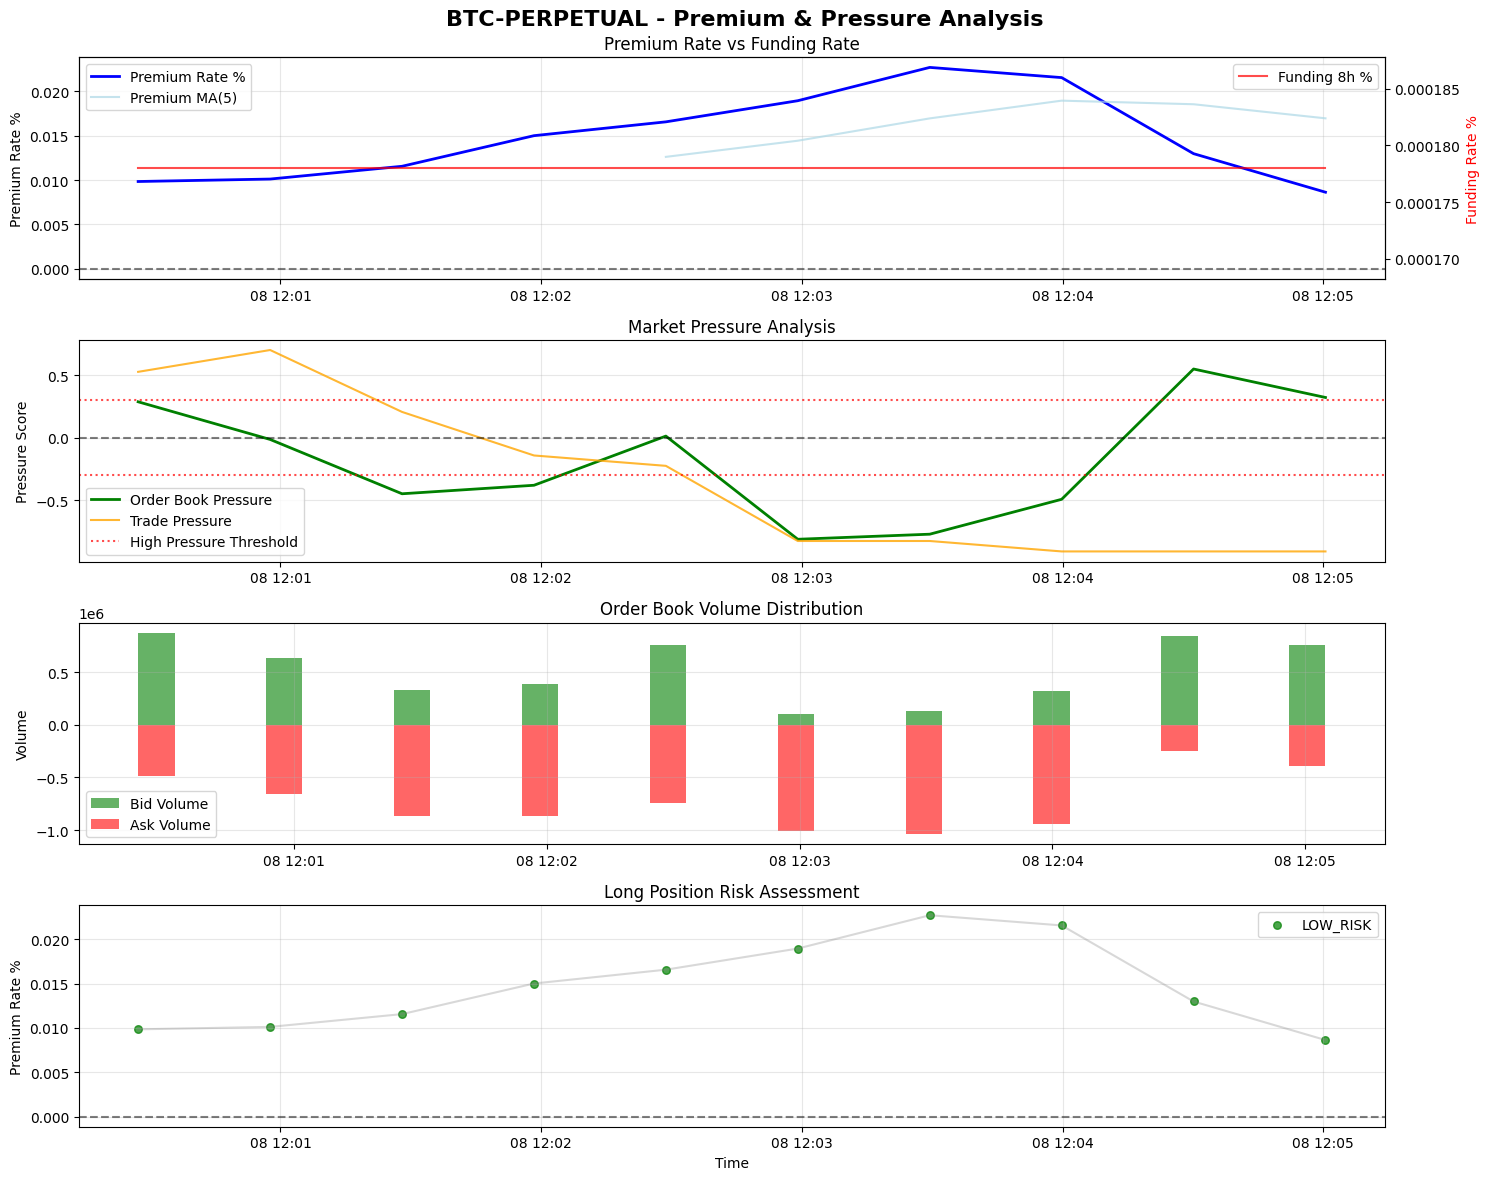

⏳ Next update in 30 seconds...

📡 Update #11/20

📊 MARKET ANALYSIS - 12:05:32
💰 Mark Price: $108,453.73
📈 Index Price: $108,445.90
💵 Premium: $+7.83 (+0.0072%)
🏦 Funding 8h: +0.0000% (Annual: +0.0%)

🔄 MARKET PRESSURE:
📊 Order Book Pressure: +0.319 📈 BUYING
💹 Trade Pressure: -0.911
📦 Bid Volume: 829,600 | Ask Volume: 427,850

⚠️ TRADING SIGNALS:
📊 Premium Trend: 🔻 DOWN
🚨 Long Risk Level: LOW_RISK
🔮 Funding Prediction: INCREASING
⏳ Next update in 30 seconds...

📡 Update #12/20

📊 MARKET ANALYSIS - 12:06:02
💰 Mark Price: $108,459.98
📈 Index Price: $108,453.92
💵 Premium: $+6.06 (+0.0056%)
🏦 Funding 8h: +0.0000% (Annual: +0.0%)

🔄 MARKET PRESSURE:
📊 Order Book Pressure: +0.927 📈 BUYING
💹 Trade Pressure: -0.911
📦 Bid Volume: 1,315,810 | Ask Volume: 49,560

⚠️ TRADING SIGNALS:
📊 Premium Trend: 🔻 DOWN
🚨 Long Risk Level: LOW_RISK
🔮 Funding Prediction: INCREASING
⏳ Next update in 30 seconds...

📡 Update #13/20

📊 MARKET ANALYSIS - 12:06:32
💰 Mark Price: $108,465.03
📈 Index Price: $108,462.64
💵 

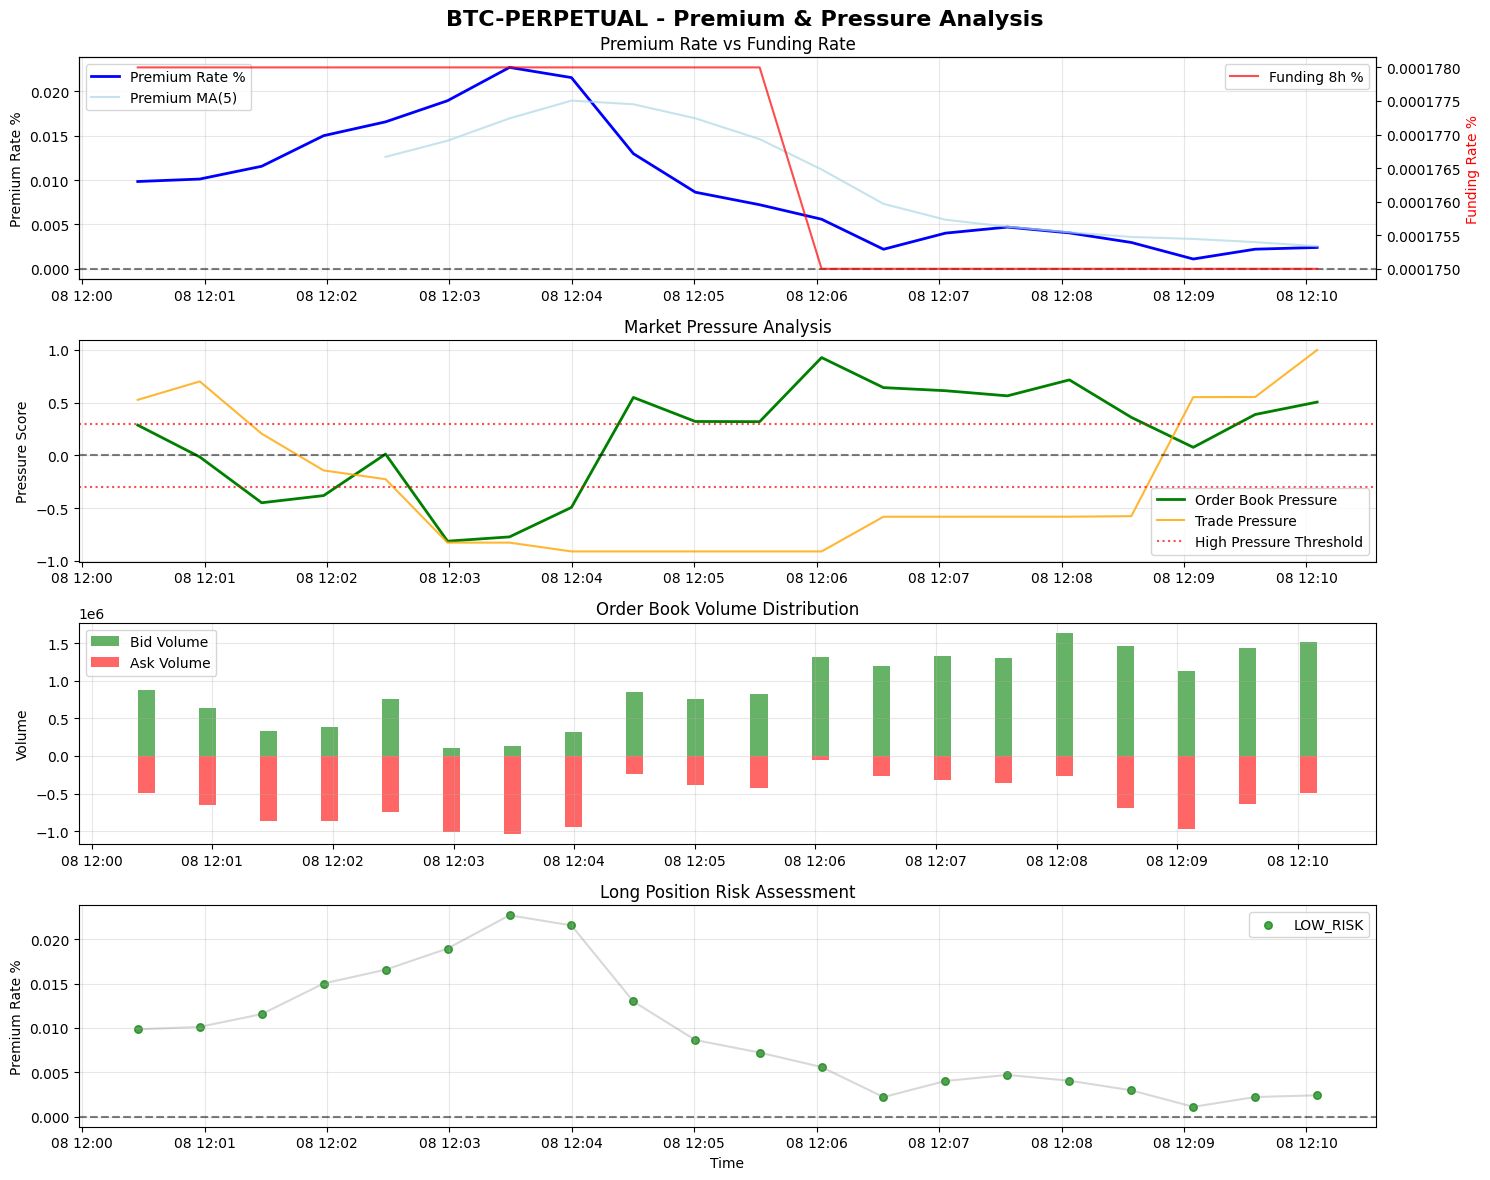


✅ Monitoring completed. Collected 20 data points.
📊 Creating final dashboard...
📊 Chart saved as PNG file


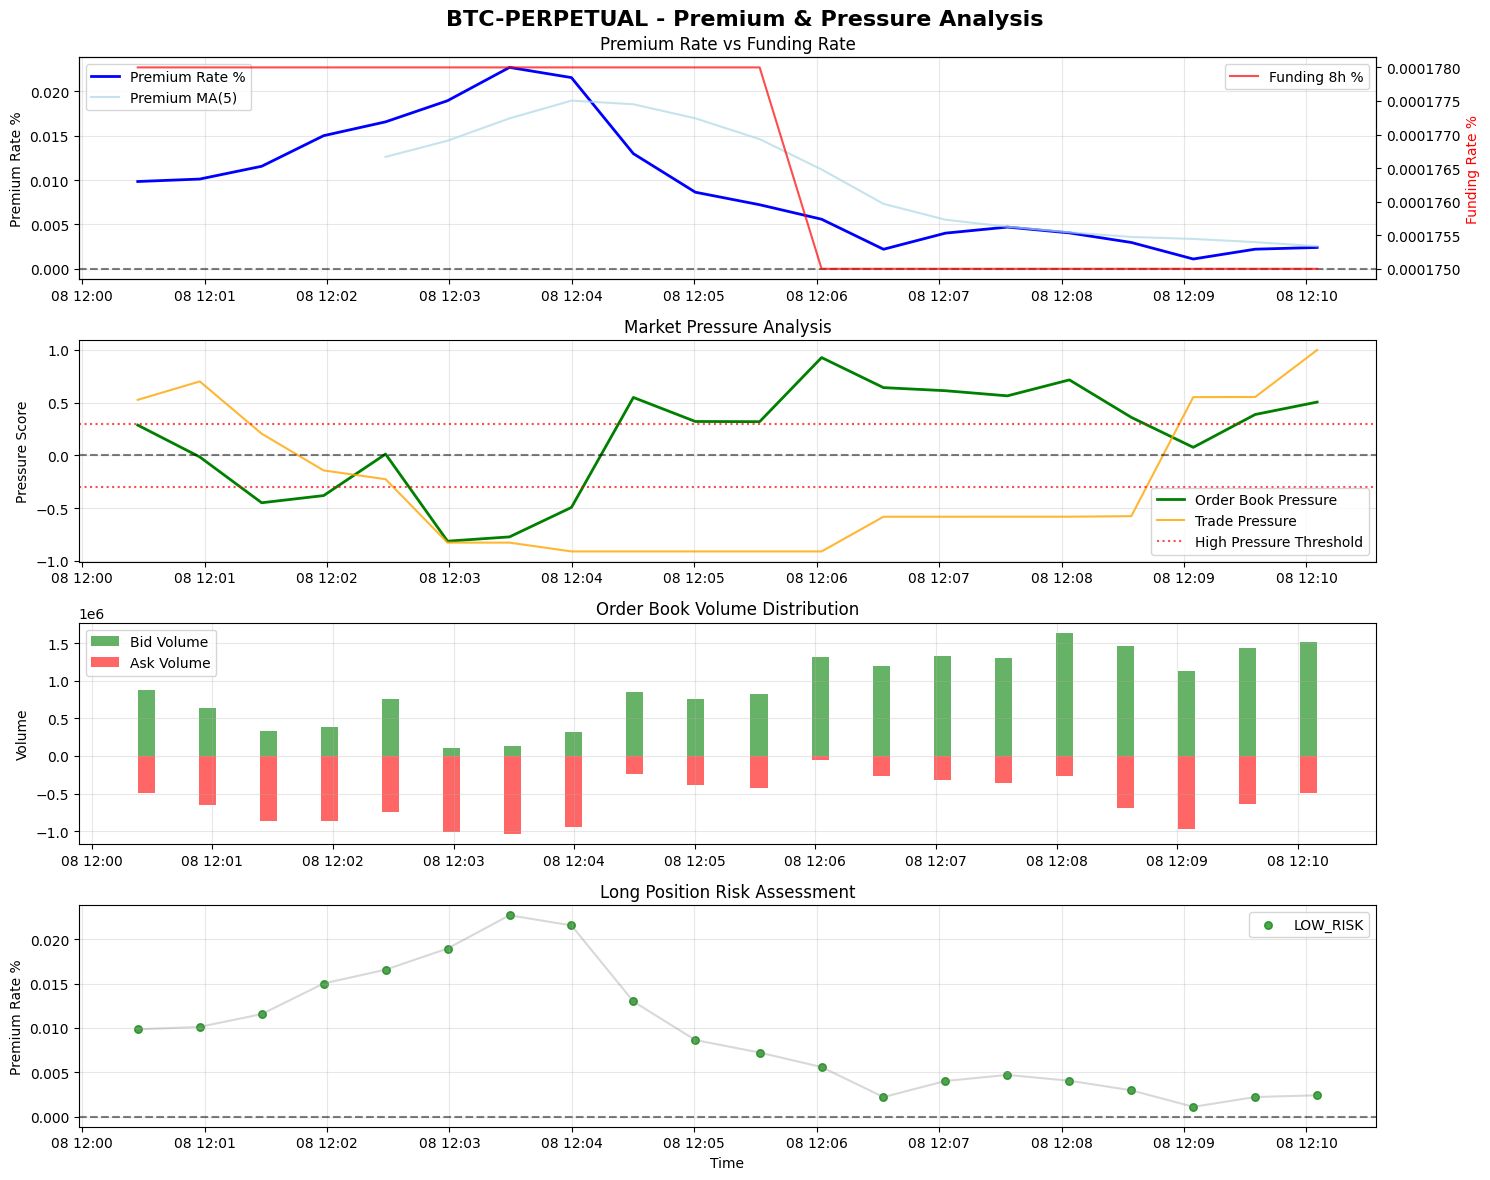

In [4]:
run_demo_monitoring()